In [1067]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import joblib
from sklearn.svm import SVC

In [1068]:
df = pd.read_csv("dataFinal.csv", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   gender                            3212 non-null   int64
 1   age                               3212 non-null   int64
 2   education                         3212 non-null   int64
 3   work_status                       3212 non-null   int64
 4   injured_past_year                 3212 non-null   int64
 5   head_injury                       3212 non-null   int64
 6   chest_injury                      3212 non-null   int64
 7   back_injury                       3212 non-null   int64
 8   stomach_injury                    3212 non-null   int64
 9   upper_body_injury                 3212 non-null   int64
 10  lower_body_injury                 3212 non-null   int64
 11  bruises                           3212 non-null   int64
 12  cuts                              

In [1069]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    2684
1     528
Name: count, dtype: int64

In [1070]:
df_0 = df[df['emotional_mental_health_disorder'] == 0]
df_1 = df[df['emotional_mental_health_disorder'] == 1]

df_0_sample = df_0.sample(n=528)
df_1_sample = df_1.sample(n=528)

In [1071]:
df_mental = pd.concat([df_0_sample, df_1_sample])

df_mental.sample(frac=1, random_state=42).reset_index(drop=True)

,gender,age,education,work_status,injured_past_year,head_injury,chest_injury,back_injury,stomach_injury,upper_body_injury,...,missing_body_parts,permanent_injury,place_of_injury,emotional_mental_health_disorder,has_injury,total_injuries,weighted_injury_severity,total_injury_severity,injured_body_parts_count,severe_injuries_count
0,2,36,4,6,1,2,2,2,2,1,...,2,2,5,0,1,16,97,29,16,13
1,2,46,2,8,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,58,3,8,1,2,2,1,2,2,...,2,2,4,1,1,16,98,30,16,14
3,2,50,2,6,1,2,2,2,2,2,...,2,2,2,1,1,16,99,30,16,14
4,2,39,5,8,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,2,63,1,6,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1052,2,66,1,6,1,2,2,2,2,2,...,2,2,5,0,1,16,98,30,16,14
1053,2,75,1,6,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1054,2,51,3,6,1,2,2,2,2,2,...,2,2,5,1,1,16,97,29,16,13


In [1072]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    2684
1     528
Name: count, dtype: int64

In [1073]:
X = df_mental.drop(['emotional_mental_health_disorder'], axis=1).values
y = df_mental['emotional_mental_health_disorder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

In [1074]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
rf_model = grid_search.best_estimator_
rf_pred = rf_model.predict(X_test_pca)
rf_acc = accuracy_score(y_test, rf_pred) * 100
print(f"RF Accuracy: {rf_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, rf_pred))

RF Accuracy: 59.94% (Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200})
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       166
           1       0.57      0.64      0.60       151

    accuracy                           0.60       317
   macro avg       0.60      0.60      0.60       317
weighted avg       0.60      0.60      0.60       317



In [1075]:
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9]}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
xgb_model = grid_search.best_estimator_
xgb_pred = xgb_model.predict(X_test_pca)
xgb_acc = accuracy_score(y_test, xgb_pred) * 100
print(f"XGBoost Accuracy: {xgb_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 67.19% (Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50})
              precision    recall  f1-score   support

           0       0.72      0.62      0.66       166
           1       0.64      0.73      0.68       151

    accuracy                           0.67       317
   macro avg       0.68      0.67      0.67       317
weighted avg       0.68      0.67      0.67       317



c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [1076]:
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
lr_model = grid_search.best_estimator_
lr_pred = lr_model.predict(X_test_pca)
lr_acc = accuracy_score(y_test, lr_pred) * 100
print(f"Logistic Regression Accuracy: {lr_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 66.25% (Best Params: {'C': 0.1, 'solver': 'lbfgs'})
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       166
           1       0.63      0.69      0.66       151

    accuracy                           0.66       317
   macro avg       0.66      0.66      0.66       317
weighted avg       0.66      0.66      0.66       317



In [1077]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}
grid_search = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
mlp_model = grid_search.best_estimator_
mlp_pred = mlp_model.predict(X_test_pca)
mlp_acc = accuracy_score(y_test, mlp_pred) * 100
print(f"MLP Accuracy: {mlp_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, mlp_pred))

MLP Accuracy: 66.88% (Best Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'sgd'})
              precision    recall  f1-score   support

           0       0.71      0.63      0.66       166
           1       0.64      0.72      0.67       151

    accuracy                           0.67       317
   macro avg       0.67      0.67      0.67       317
weighted avg       0.67      0.67      0.67       317



In [1078]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
svm_model = grid_search.best_estimator_
svm_pred = svm_model.predict(X_test_pca)
svm_acc = accuracy_score(y_test, svm_pred) * 100
print(f"SVM Accuracy: {svm_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 66.88% (Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'})
              precision    recall  f1-score   support

           0       0.71      0.63      0.66       166
           1       0.64      0.72      0.67       151

    accuracy                           0.67       317
   macro avg       0.67      0.67      0.67       317
weighted avg       0.67      0.67      0.67       317



In [1079]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
knn_model = grid_search.best_estimator_
knn_pred = knn_model.predict(X_test_pca)
knn_acc = accuracy_score(y_test, knn_pred) * 100
print(f"KNN Accuracy: {knn_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, knn_pred))

KNN Accuracy: 58.04% (Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'})
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       166
           1       0.56      0.57      0.56       151

    accuracy                           0.58       317
   macro avg       0.58      0.58      0.58       317
weighted avg       0.58      0.58      0.58       317



In [1080]:
print(f"Accuracy Scores:\nLogistic Regression: {lr_acc:.2f}\nXGBoost: {xgb_acc:.2f}\nRandom Forest: {rf_acc:.2f}\nNeural Network: {mlp_acc:.2f}\nSVM: {svm_acc:.2f}\nk-NN: {knn_acc:.2f}")

Accuracy Scores:
Logistic Regression: 66.25
XGBoost: 67.19
Random Forest: 59.94
Neural Network: 66.88
SVM: 66.88
k-NN: 58.04


In [1081]:
print(f"{rf_acc:.2f} {xgb_acc:.2f} {lr_acc:.2f} {mlp_acc:.2f} {svm_acc:.2f} {knn_acc:.2f}")

59.94 67.19 66.25 66.88 66.88 58.04


In [1082]:
# def pickleModel(model, filename):
#     pickle.dump(model, open(filename, 'wb'))

# pickleModel(rf_model, 'models/RF.pkl')
# pickleModel(xgb_model, 'models/XGB.pkl')
# pickleModel(lr_model, 'models/LR.pkl')
# pickleModel(mlp_model, 'models/NN.pkl')
# pickleModel(svm_model, 'models/SVM.pkl')
# pickleModel(knn_model, 'models/KNN.pkl')

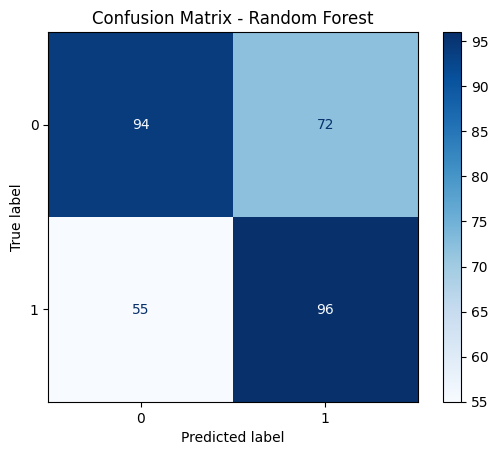

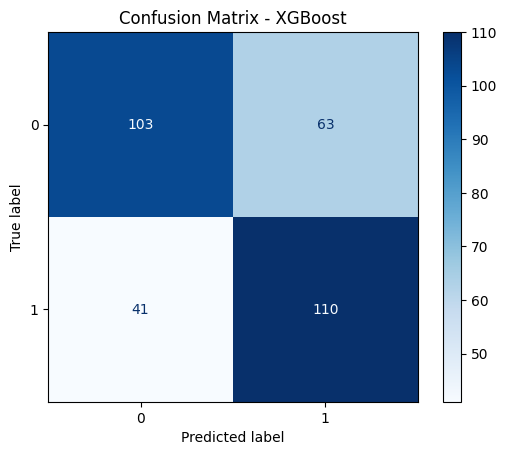

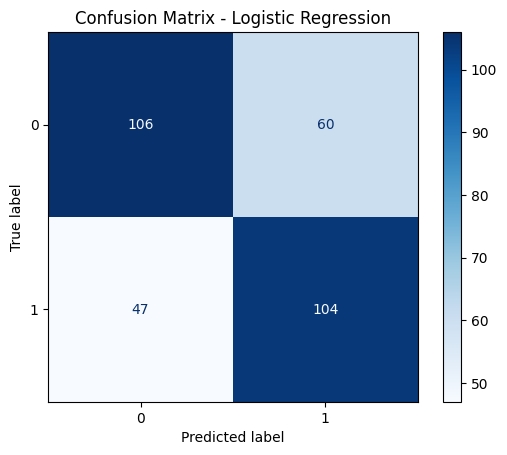

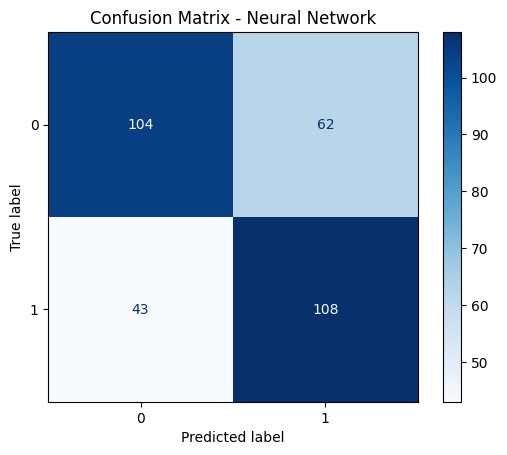

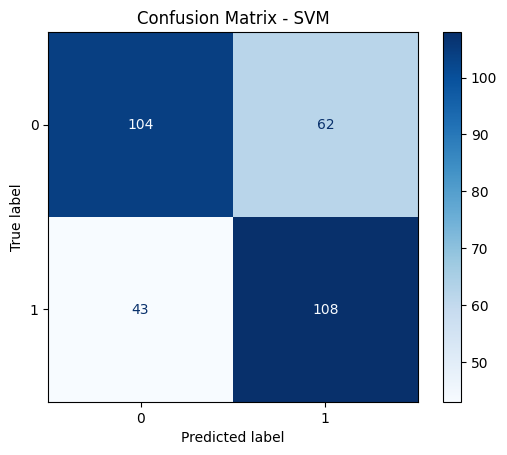

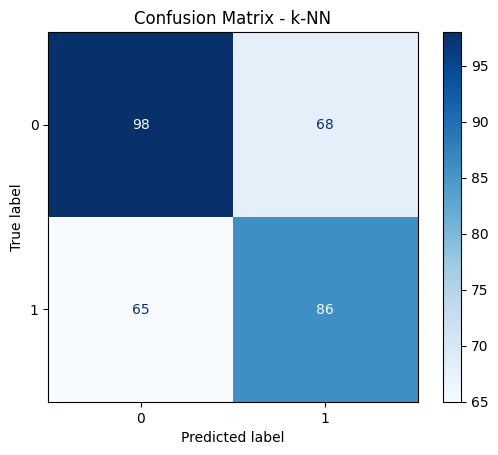

In [1083]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, rf_pred, "Random Forest")
plot_confusion_matrix(y_test, xgb_pred, "XGBoost")
plot_confusion_matrix(y_test, lr_pred, "Logistic Regression")
plot_confusion_matrix(y_test, mlp_pred, "Neural Network")
plot_confusion_matrix(y_test, svm_pred, "SVM")
plot_confusion_matrix(y_test, knn_pred, "k-NN")

In [1084]:

# top_5_features = feature_importances.nlargest(5, "Importance")["Feature"]

# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

# for i, feature in enumerate(top_5_features):
#     grouped_df = df.groupby(feature)[target_variable].value_counts(normalize=True).unstack()
    
#     grouped_df.plot(kind='bar', stacked=True, ax=axes[i], colormap="coolwarm", alpha=0.85)
    
#     axes[i].set_title(feature)
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Proportion")
#     axes[i].legend(title="Emotional Mental Health Disorder", labels=["0 (No)", "1 (Yes)"])

# plt.tight_layout()
# plt.show()

